In [2]:
from utils import Graph
import scipy.interpolate as interpolate
import glob
import re
from matplotlib import pyplot as plt
import numpy as np

# Different pressure levels
P_v = [2, 7, 15]
N_v = [1.15e19, 4.02e19, 8.61e19]
colors = ['C0', 'C1', 'C3']
colors_th = ['C2', 'C4', 'C5']

# Different cross section databases
databases = ['Biagi', 'BSR', 'Puech']
style = ['-', '-.', ':']

def alpha(P,E,A,B):
    return P * A * np.exp(-B*P/E)

def reduced_alpha(x, A,B):
    return A * np.exp(-B/x)

def M(alpha,dx):
    return np.exp(alpha * dx)

def psi_to_torr(p):
    return p * 51.7149

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

The below imports and processes the necessary files across datasets and pressures.

In [3]:
file_tree = [[{}, {}, {}], [{}, {}, {}]]

file_tree_total = [[[{}, {}, {}], [{}, {}, {}]], [[{}, {}, {}], [{}, {}, {}]], [[{}, {}, {}], [{}, {}, {}]]]

E_vals = [[[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]]]
alpha_vals = [[[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]]]
M_vals = [[[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]]]

for k, db in enumerate(databases):
    for j, d in enumerate([1, 3]):
        for i, p in enumerate(P_v):
            for file in glob.glob(f'gar-townsend-coef/{db}/{p}-psi/{d}d/*.txt'):
                key = int(re.search(r'(\d*)(?:V)', file).group(1))
                if (key in file_tree_total[k][j][i]):
                    file_tree_total[k][j][i][key].append(file)
                else:
                    file_tree_total[k][j][i][key] = [file]

            for key, value in sorted(file_tree_total[k][j][i].items()):
                group = Graph(value)
                E_vals[k][j][i].append(key)
                alpha_vals[k][j][i].append(group.alpha(recursive=False))
                M_vals[k][j][i].append(group.M(recursive=False))

The below plots the simulated Townsend coefficient.

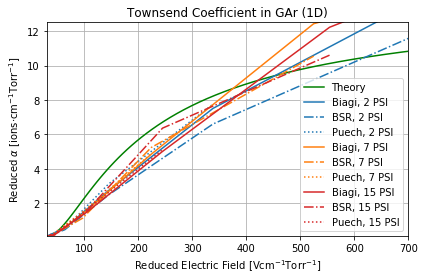

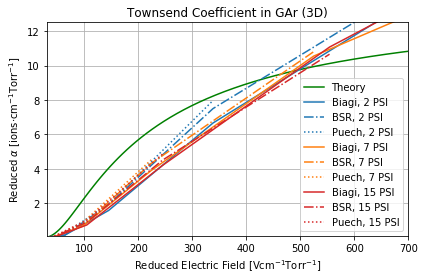

In [3]:
x_v = np.logspace(1,3,100)
alpha_red_v_1 = reduced_alpha(x_v, 14, 180)

for j, d in enumerate([1, 3]):
    # plt.rcParams['font.size'] = 14
    # plt.rcParams['font.family'] = 'serif'
    # fig = plt.figure(figsize=(6, 6))
    
    plt.plot(x_v, alpha_red_v_1, 'g', label=r'Theory')
    
    for i, p in enumerate(P_v):
        for k, db in enumerate(databases):
            plt.plot([v / psi_to_torr(p) for v in E_vals[k][j][i]], [a / psi_to_torr(p) for a in alpha_vals[k][j][i]], colors[i], linestyle=style[k], label=f'{db}, {p} PSI')
            
    plt.title(f'Townsend Coefficient in GAr ({d}D)')
    plt.xlabel('Reduced Electric Field [Vcm$^{-1}$Torr$^{-1}$]')
    plt.ylabel('Reduced $\\alpha$ [ions$\cdot$cm$^{-1}$Torr$^{-1}$]')
    
    plt.xlim(3e1, 7e2)
    plt.ylim(1e-1, 1.25e1)
    
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # plt.savefig(f'gar_townsend_{d}d.pdf', bbox_inches='tight')

The below plots the simulated electron multiplication factor. The late onset and lack of saturation is directly inferable from the above plot of the Townsend coefficient.

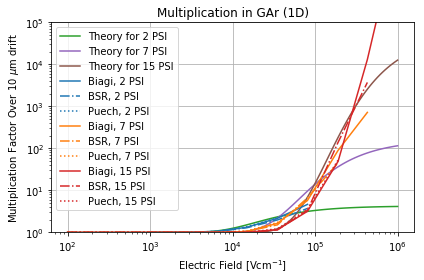

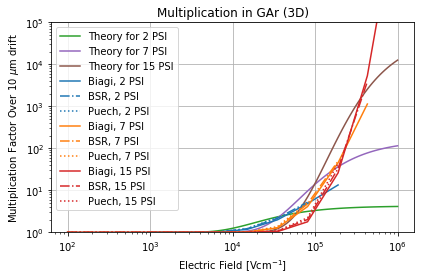

In [5]:
E_v = np.logspace(3, 6, 100)

for j, d in enumerate([1, 3]):
    # plt.rcParams['font.size'] = 14
    # plt.rcParams['font.family'] = 'serif'
    # fig = plt.figure(figsize=(6, 6))
    
    for i, p in enumerate(P_v):
        a_v = alpha(psi_to_torr(p), E_v, 14, 180)
        mult_v = M(a_v, 10 * 1e-4)
        plt.plot(E_v, mult_v, colors_th[i], label=f'Theory for {p} PSI')
        
    for i, p in enumerate(P_v):
        for k, db in enumerate(databases):
            plt.plot(E_vals[k][j][i], M_vals[k][j][i], colors[i], linestyle=style[k], label=f'{db}, {p} PSI')
            
    plt.xlabel('Electric Field [Vcm$^{-1}$]')
    plt.ylabel('Multiplication Factor Over 10 $\mu$m drift')
    plt.title(f'Multiplication in GAr ({d}D)')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1, 1e5)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # plt.savefig(f'gar_mult_{d}d.pdf', bbox_inches='tight')